# Data Science Internship
# - Anisha Walde

# Project 01: Gender and age detection system 

**Objective :** Implement a gender and age detection system using face recognition to identify individuals and infer their age and gender from images.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import cv2
import os
import tensorflow as tf
from pathlib import Path
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
path = "C:/Users/Hp/Downloads/crop_part1/crop_part10"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 589
100_1_0_20170110183726390.jpg.chip.jpg


In [3]:
gender_list=[]
age_list=[]
img_paths = []
for filename in os.listdir(path):
    img_path = os.path.join(path,filename)
    temp = filename.split('_')
    age_list.append(int(temp[0]))
    gender_list.append(int(temp[1]))
    img_paths.append(img_path)

# Data preprocessing

In [4]:
df = pd.DataFrame()
df['image'], df['gender'], df['age'] = img_paths, gender_list, age_list
df.head()

,image,gender,age
0,C:/Users/Hp/Downloads/crop_part1/crop_part10\1...,1,100
1,C:/Users/Hp/Downloads/crop_part1/crop_part10\1...,1,100
2,C:/Users/Hp/Downloads/crop_part1/crop_part10\1...,1,101
3,C:/Users/Hp/Downloads/crop_part1/crop_part10\1...,1,110
4,C:/Users/Hp/Downloads/crop_part1/crop_part10\1...,0,12


In [5]:
gender_dict = df['gender'].replace({0:"Male",1:"Female"})

# Exploratory Data Analysis

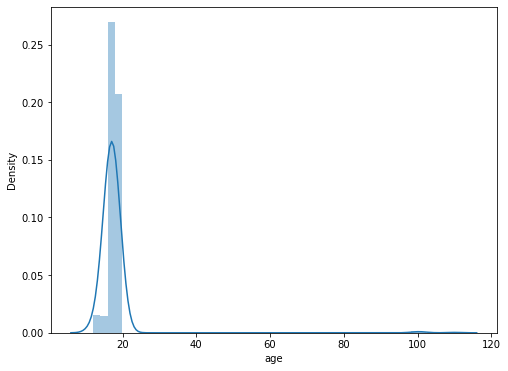

In [6]:
plt.figure(figsize=(8, 6))
sns.distplot(df['age']);

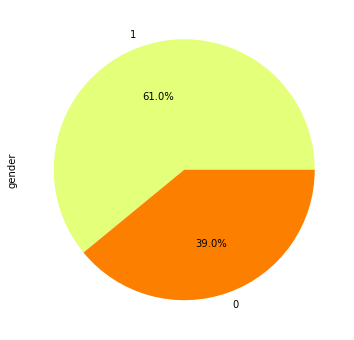

In [7]:
plt.figure(figsize=(8, 6))
df['gender'].value_counts().plot(kind='pie',autopct="%.1f%%", colormap='Wistia');

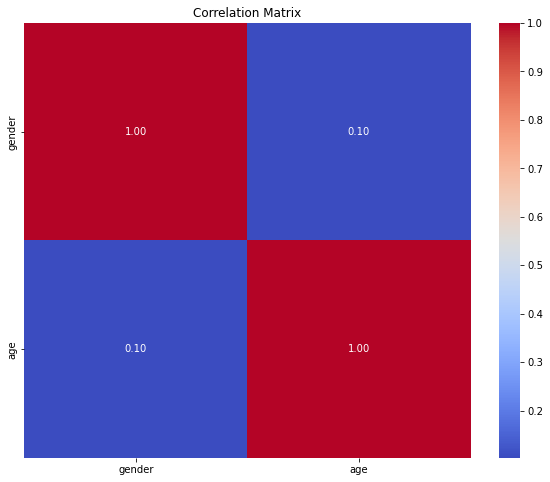

In [8]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f");
plt.title('Correlation Matrix');

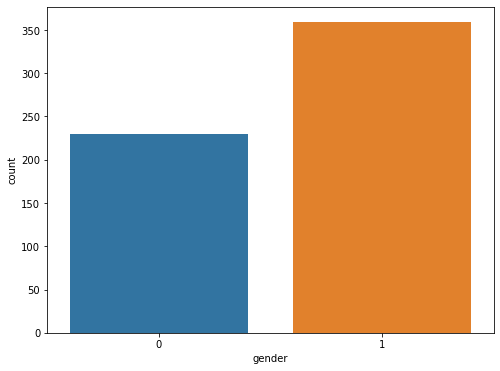

In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='gender');

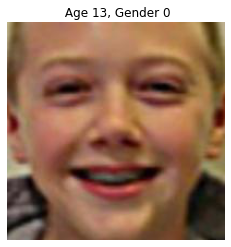

In [10]:
from PIL import Image
img = Image.open(df['image'][15])
plt.title(f' Age {df.age[15]}, Gender {df.gender.loc[15]}')
plt.axis('off')
plt.imshow(img);

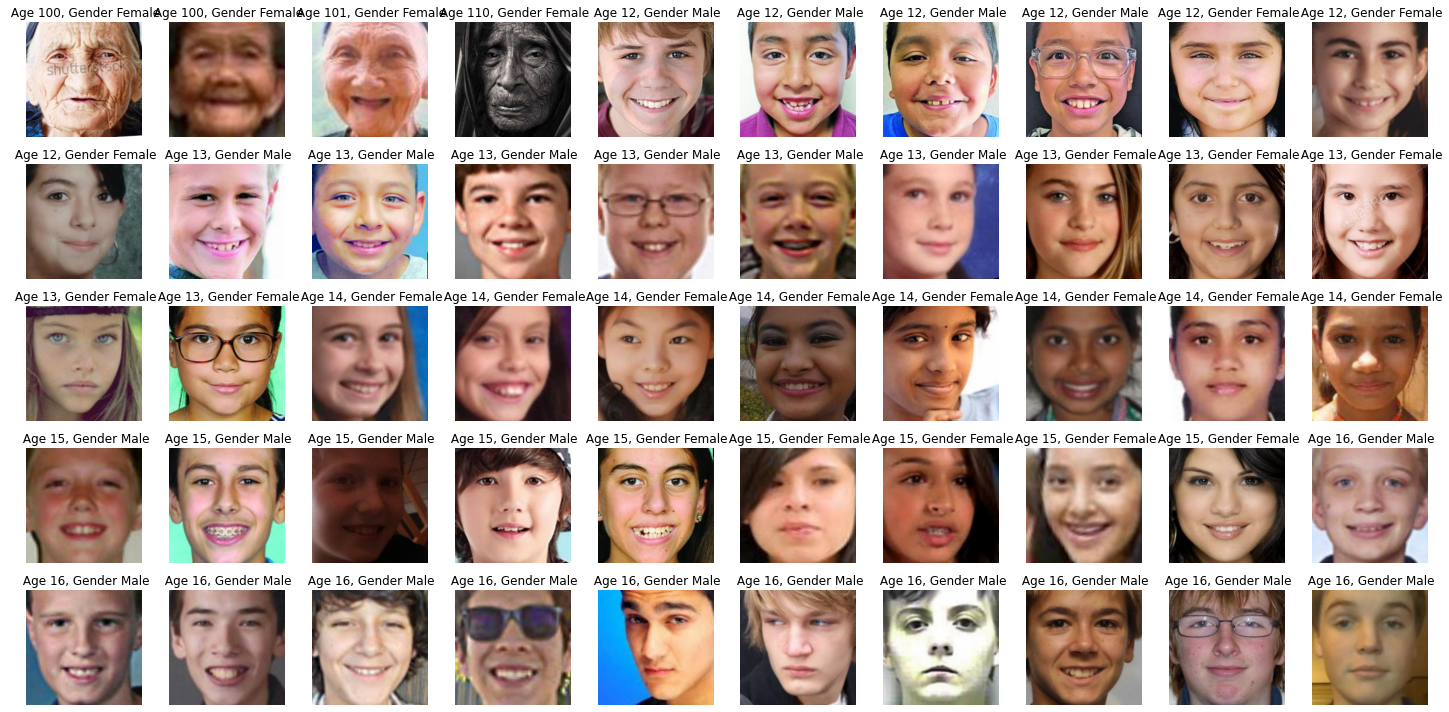

In [11]:
plt.figure(figsize=(20,10))
for i in range (50):
    plt.subplot(5,10,i+1)
    img = Image.open(df['image'][i])
    plt.title(f' Age {df.age[i]}, Gender {gender_dict.loc[i]}')
    plt.imshow(img);
    plt.axis('off')
plt.tight_layout()

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split

In [13]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [24]:
#converting Image to numpy array 
x_train = []
for file in train.image:
    img = load_img(file, grayscale=True)
    img = img.resize((128,128))
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128, 128, 1)

# Normalizing data

In [25]:
x_train = x_train/255

# Train and Test

In [26]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [27]:
input_size = (128, 128, 1)

In [28]:
# Building the CNN model
inputs = Input(shape=input_size)
X = Conv2D(300, (3, 3), activation='relu')(inputs)
X = BatchNormalization(axis=3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(300, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(500, activation='relu')(X)
dense_2 = Dense(500, activation='relu')(X)
dense_3 = Dense(400, activation='relu')(dense_2)
dropout_1 = Dropout(0.6)(dense_1)
dropout_2 = Dropout(0.6)(dense_3)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)
age_output = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[gender_output, age_output])

In [29]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',restore_best_weights=True),
]

In [30]:
model.compile(optimizer='adam',loss={'age_output':'mae','gender_output':'binary_crossentropy'},metrics={'age_output':'mae','gender_output':'accuracy'})

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 126, 126, 300)        3000      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 126, 126, 300)        1200      ['conv2d_3[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 42, 42, 300)          0         ['batch_normalization_1[

In [32]:
model_history= model.fit(x=x_train, y=[y_gender, y_age], batch_size = 128, epochs=30, validation_split= 0.2,callbacks=callbacks, shuffle=True)

Epoch 1/30
3/3 [==============================] - 146s 44s/step - loss: 34.2530 - gender_output_loss: 7.8768 - age_output_loss: 26.3762 - gender_output_accuracy: 0.5612 - age_output_mae: 26.3762 - val_loss: 18.4215 - val_gender_output_loss: 0.7058 - val_age_output_loss: 17.7157 - val_gender_output_accuracy: 0.3579 - val_age_output_mae: 17.7157
Epoch 2/30
3/3 [==============================] - 108s 37s/step - loss: 17.1803 - gender_output_loss: 0.7734 - age_output_loss: 16.4068 - gender_output_accuracy: 0.5053 - age_output_mae: 16.4068 - val_loss: 17.7878 - val_gender_output_loss: 0.6792 - val_age_output_loss: 17.1087 - val_gender_output_accuracy: 0.6421 - val_age_output_mae: 17.1087
Epoch 3/30
3/3 [==============================] - 165s 64s/step - loss: 9.8518 - gender_output_loss: 0.8180 - age_output_loss: 9.0338 - gender_output_accuracy: 0.5984 - age_output_mae: 9.0338 - val_loss: 16.3043 - val_gender_output_loss: 0.6845 - val_age_output_loss: 15.6198 - val_gender_output_accuracy: 0.

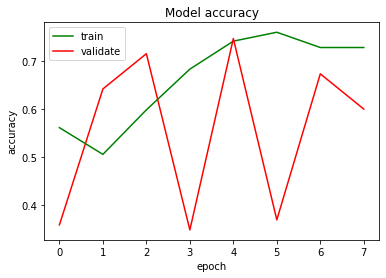

In [33]:
plt.plot(model_history.history['gender_output_accuracy'], 'green')
plt.plot(model_history.history['val_gender_output_accuracy'], 'red')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left');

**Thank You**